<a href="https://colab.research.google.com/github/mannam95/Deep_Learning_Programming/blob/main/Assignment10/Assignment_10_IDL_Adversarial_Meghana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Team Assignment

1. Srinath Mannam (229750)
2. Meghana Rao (234907)
3. Govind Shukla (235192)



##Import Statements


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

##Load Dataset

170508288/170498071 [==============================] - 3s 0us/step


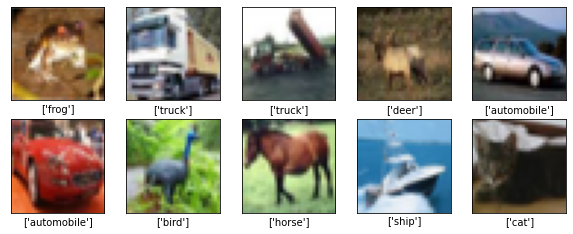

In [ ]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

train_data = tf.data.Dataset.from_tensor_slices((train_images.reshape([-1, 32, 32, 3]).astype(np.float32) / 255, train_labels.astype(np.int32).reshape(-1)))
train_data = train_data.shuffle(buffer_size=60000).batch(100).repeat(10)
test_data = tf.data.Dataset.from_tensor_slices((test_images.reshape([-1, 32, 32, 3]).astype(np.float32) / 255, test_labels.astype(np.int32).reshape(-1))).batch(100)

cifar_10_class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(np.array(cifar_10_class_labels)[train_labels[i].astype(int)])
plt.show()


##Model

In [ ]:
input_shape = (32, 32, 3)
num_classes = 10
layer_list = [tf.keras.layers.Conv2D(64,(3, 3), padding='same', activation='relu',input_shape=input_shape),
              tf.keras.layers.MaxPool2D(),
              tf.keras.layers.Conv2D(128,(3, 3), padding='same', activation='relu'),
              tf.keras.layers.MaxPool2D(),
              tf.keras.layers.Conv2D(256,(3, 3), padding='same', activation='relu'),
              tf.keras.layers.MaxPool2D(),                
              tf.keras.layers.Flatten(),
              tf.keras.layers.Dropout(0.3),
              tf.keras.layers.Dense(64, activation=tf.nn.leaky_relu),
              tf.keras.layers.Dense(32, activation=tf.nn.leaky_relu),
              tf.keras.layers.Dense(num_classes, activation='softmax')]

model = tf.keras.Sequential(layer_list)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 128)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)         295168    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 256)        0

In [ ]:
optimizer = tf.optimizers.Adam() 
loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=False)
train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
test_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()

In [ ]:
def start_conv_model_train(train_data, model):
  for step, (image_batch, label_batch) in enumerate(train_data):

    with tf.GradientTape() as tape:
      logits = model(image_batch)
      loss = loss_fn(label_batch, logits)

    gradients = tape.gradient(loss, model.trainable_variables)
      
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    train_acc_metric(label_batch, logits)
    
    if not step % 500:
        print("Loss: {} Accuracy: {}".format(loss, train_acc_metric.result()))
        train_acc_metric.reset_states()

In [ ]:
def start_conv_model_test(test_data, model):
  predictions = []
  for image_batch, label_batch in test_data:
    test_acc_metric(label_batch, model(image_batch))
    predictions.append(tf.argmax(model(image_batch),axis=1,output_type=tf.int32))
  print("Test acc: {}".format(test_acc_metric.result()))
  return predictions

## Model Train

In [ ]:
start_conv_model_train(train_data, model)

Loss: 2.311671257019043 Accuracy: 0.09000000357627869
Loss: 1.1560683250427246 Accuracy: 0.46597999334335327
Loss: 0.9037014245986938 Accuracy: 0.6453800201416016
Loss: 0.700653076171875 Accuracy: 0.7185199856758118
Loss: 0.5984536409378052 Accuracy: 0.7638000249862671
Loss: 0.6102252006530762 Accuracy: 0.8014400005340576
Loss: 0.4454277753829956 Accuracy: 0.8317999839782715
Loss: 0.2168990522623062 Accuracy: 0.859499990940094
Loss: 0.25380897521972656 Accuracy: 0.8867200016975403
Loss: 0.20956502854824066 Accuracy: 0.9104200005531311


## Model Test

In [ ]:
original_predictions = start_conv_model_test(test_data, model)

Test acc: 0.7498000264167786


## Generate Adversarial Data

In [ ]:
def generate_adversarial_data(data, model, epsilon):
  original_data = []
  adversarial_data = []
  data_labels = []

  for image_batch, label_batch in data:
    with tf.GradientTape() as tape:
      tape.watch(image_batch)
      logits = model(image_batch)
      loss = loss_fn(label_batch, logits)

    gradient_images = tape.gradient(loss, image_batch)
    # gradient sign method. you can fiddle with epsilon. the larger, the more dramatic the effect.
    # but if it's too large, it doesn't really qualify as an adversarial example anymore!
    # clip to between 0 and 1 since adding the gradient might take the images out of that range.
    adversarial_img_batch = tf.clip_by_value(image_batch + epsilon*tf.math.sign(gradient_images), clip_value_min=0., clip_value_max=1.)

    original_data.append(image_batch)
    adversarial_data.append(adversarial_img_batch)
    data_labels.append(label_batch)

  return original_data, adversarial_data, data_labels

In [ ]:
epsilon = 0.02
original_image_data, adversarial_image_data, image_data_labels = generate_adversarial_data(test_data, model, epsilon)

In [ ]:
adversarial_image_dataset = tf.data.Dataset.from_tensor_slices((adversarial_image_data, image_data_labels))

###Model's performance on generated adversarial test data

In [ ]:
_ = start_conv_model_test(adversarial_image_dataset, model)

Test acc: 0.4161500036716461


## Adversarial Training

In [ ]:
def start_adversarial_training(train_data, model, epsilon):
  train_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
  for step, (image_batch, label_batch) in enumerate(train_data):
    with tf.GradientTape() as tape:
      tape.watch(image_batch)
      logits = model(image_batch)
      loss = loss_fn(label_batch, logits)
    gradients = tape.gradient(loss,image_batch)
    adversarial_img_batch = tf.clip_by_value(image_batch + epsilon * tf.math.sign(gradients), clip_value_min=0., clip_value_max=1.)

    with tf.GradientTape() as tape:
      logits = model(adversarial_img_batch)
      loss = loss_fn(label_batch, logits)
    train_acc_metric.update_state(label_batch, logits)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    if not step % 500:
      print("Loss: {} Accuracy: {}".format(loss, train_acc_metric.result()))
      train_acc_metric.reset_states()
    

In [ ]:
def start_adversarial_testing(test_data, model):
  predictions = []
  test_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy()
  for image_batch, label_batch in test_data:
    test_acc_metric(label_batch, model(image_batch))
    predictions.append(tf.argmax(model(image_batch),axis=1,output_type=tf.int32))
  print("Test acc: {}".format(test_acc_metric.result()))
  return predictions

## Adversarial trained model's performance

####Train

In [ ]:
start_adversarial_training(train_data, model, 0.02)

Loss: 7.945530414581299 Accuracy: 0.05999999865889549
Loss: 1.9787306785583496 Accuracy: 0.23243999481201172
Loss: 1.6270390748977661 Accuracy: 0.30118000507354736
Loss: 1.7616878747940063 Accuracy: 0.331279993057251
Loss: 1.750536322593689 Accuracy: 0.3548400104045868
Loss: 1.60426664352417 Accuracy: 0.37356001138687134
Loss: 1.6828471422195435 Accuracy: 0.3885999917984009
Loss: 1.5196048021316528 Accuracy: 0.40202000737190247
Loss: 1.5631017684936523 Accuracy: 0.41596001386642456
Loss: 1.483535885810852 Accuracy: 0.4267599880695343


#### Test

In [ ]:
adversarial_predictions = start_adversarial_testing(adversarial_image_dataset, model)

Test acc: 0.5949000120162964


In [ ]:
_ = start_adversarial_testing(test_data, model)

Test acc: 0.6384000182151794


#### Train the model with epsilon = 0.1

In [ ]:
start_adversarial_training(train_data, model, 0.1)

Loss: 2.9161627292633057 Accuracy: 0.07000000029802322
Loss: 2.2374236583709717 Accuracy: 0.13729999959468842
Loss: 2.2997634410858154 Accuracy: 0.16047999262809753
Loss: 2.2513270378112793 Accuracy: 0.16704000532627106
Loss: 2.2604780197143555 Accuracy: 0.17212000489234924
Loss: 2.2689363956451416 Accuracy: 0.18019999563694
Loss: 2.1860570907592773 Accuracy: 0.1873999983072281
Loss: 2.0790462493896484 Accuracy: 0.20562000572681427
Loss: 1.5488086938858032 Accuracy: 0.35604000091552734
Loss: 0.9788862466812134 Accuracy: 0.5115000009536743


####Test the model with epsilon = 0.1

In [ ]:
_ = start_adversarial_testing(adversarial_image_dataset, model)

Test acc: 0.4674000144004822
